# Convolutional Neural Netwrok Models for Pneumonia Detection in X-Ray Images

<ol start="0">
<li>Train/Test Image Generation</li>
<li>LeNet</li>
<li>AlexNet</li>
<li>VGG16
  <ul style="list-style-type: decimal;">
    <li>VGG16 built-in Keras</li>
    <li>VGG16 Implemented from Scratch</li>
  </ul>
</li>
<li>InceptionV3 (built-in Keras)</li>
<li>ResNet (ResNet50)
  <ul style="list-style-type: decimal;">
    <li>Model: Built-in ResNet50 with only one Fully Connected Layer</li>
    <li>Model: Built-in base model nontrainable with only one added fully connected layer</li>
    <li>Model: Built-in Resnet50 with several normalisation layers added</li>
    <li>Data: Images with rotation/height/width adjusting, Model: Built-in Resnet50 with several normalisation layers added</li>
  </ul>
</li>
</ol>

In [35]:
# update libraries
import tensorflow as tf
import numpy as np
import seaborn as sns
import lenet, alexnet
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay

## Train/Test Image Generation

In [36]:
# Defining the paths to the train and validation directories
train_dir = "train"
test_dir = "test"

# Data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_test = ImageDataGenerator(
    rescale=1./255
)

def datagen_train_dir(dir,in_shape):
    generator = datagen_train.flow_from_directory(
        dir,
        target_size=(in_shape[0], in_shape[1]),  #target_size=(224, 224),  
        batch_size=32,
        class_mode='binary',  # Since class_mode is binary, labels will be 0 or 1
        classes=['NORMAL', 'PNEUMONIA']  # Specify the class labels explicitly
        )
    return generator

def datagen_test_dir(dir,in_shape):
    generator = datagen_test.flow_from_directory(
        dir,
        target_size=(in_shape[0], in_shape[1]),  #target_size=(224, 224),  
        batch_size=32,
        class_mode='binary',  # Since class_mode is binary, labels will be 0 or 1
        classes=['NORMAL', 'PNEUMONIA']  # Specify the class labels explicitly
        )
    return generator

In [37]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [38]:
# Printing Confusion Matrix and parameters
def plot_confusion_matrix(cm, model_name, classes=['NORMAL', 'PNEUMONIA']):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show())   
    return plt.gcf()
    
def print_classification_report(y_true, y_pred_binary, model_name):
    report = classification_report(y_true, y_pred_binary, target_names=['not fractured', 'fractured'])
    accuracy = accuracy_score(y_true, y_pred_binary)
    print(f"Classification Report for {model_name}:\n")
    print(report)
    print(f"Accuracy for {model_name}: {accuracy:.2f}")

SyntaxError: unmatched ')' (2135664009.py, line 8)

## 1. LeNet

In [5]:
# Generating data for LeNet input shape
train_generator = datagen_train_dir(train_dir, (32, 32))
test_generator = datagen_test_dir(test_dir, (32, 32))

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
import lenet as lenet

lenet_model = lenet.create_lenet_model()

# Compile the model
lenet_model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
lenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,241 (239.22 KB)

 Trainable params: 61,241 (239.22 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
lenet_history = lenet_model.fit(train_generator, 
                                epochs=3, 
                                validation_data=test_generator)

Epoch 1/3


C:\Users\birce\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 121s 691ms/step - accuracy: 0.7620 - loss: 0.5376 - val_accuracy: 0.8558 - val_loss: 0.3522
Epoch 2/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 111s 654ms/step - accuracy: 0.8725 - loss: 0.2955 - val_accuracy: 0.8846 - val_loss: 0.3171
Epoch 3/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 114s 670ms/step - accuracy: 0.8815 - loss: 0.2763 - val_accuracy: 0.8894 - val_loss: 0.3006


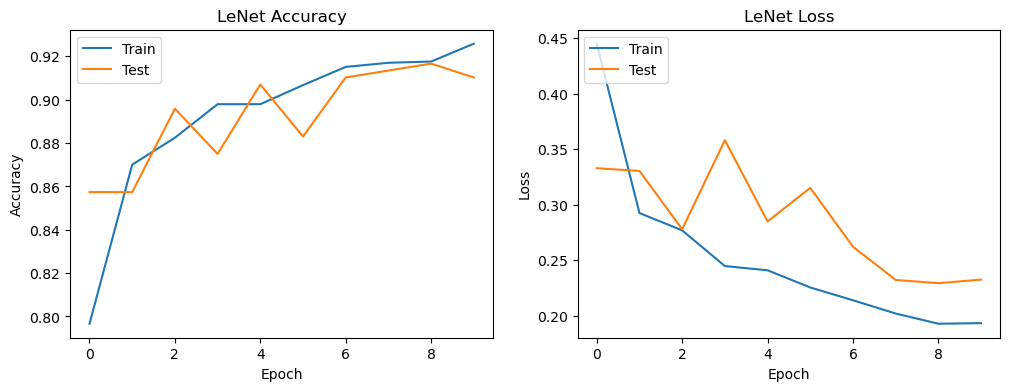

In [8]:
# plot accuracy and loss vs epoch
plot_history(lenet_history, "LeNet")

### Plotting Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


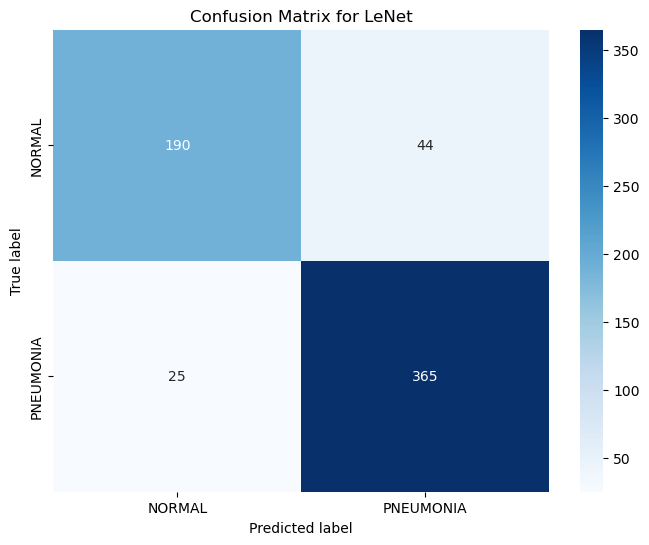

'"# Generate predictions from the test data\ny_pred = lenet_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)\n\n# Since y_pred is in probabilities, we need to convert them to binary predictions\ny_pred_binary = np.where(y_pred > 0.5, 1, 0).flatten()  # Ensure flattening if necessary\n\n# Get the true labels from the test data\ny_true = test_generator.classes\n\n# Compute the confusion matrix\ncm = confusion_matrix(y_true, y_pred_binary)\n\n# Plotting the confusion matrix\nplot_confusion_matrix(cm, "LeNet")\n\n# Print the classification report and accuracy\nprint_classification_report(y_true, y_pred_binary, "LeNet")'

<Figure size 640x480 with 0 Axes>

In [42]:
# Get true labels and predicted probabilities
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

y_true = []
y_pred = []

for i in range(test_steps_per_epoch):
    x_batch, y_batch = next(test_generator)
    y_true.extend(y_batch)
    y_pred.extend(lenet_model.predict(x_batch).ravel())

y_true = np.array(y_true)
y_pred_binary = (np.array(y_pred) > 0.5).astype(int)  # Convert probabilities to binary predictions

def plot_confusion_matrix(cm, model_name, classes=['NORMAL', 'PNEUMONIA']):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()   
    return plt.gcf()

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot confusion matrix
plot_confusion_matrix(cm, "LeNet")

""""# Generate predictions from the test data
y_pred = lenet_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0).flatten()  # Ensure flattening if necessary

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "LeNet")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "LeNet")"""

Classification Report for LeNet:
              precision    recall  f1-score   support

      NORMAL       0.88      0.81      0.85       234
   PNEUMONIA       0.89      0.94      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

Accuracy: 0.89


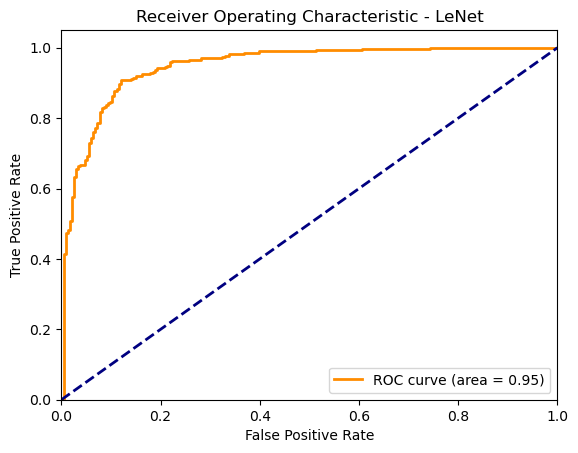

In [32]:
# Calculate classification metrics
report = classification_report(y_true, y_pred_binary, target_names=['NORMAL', 'PNEUMONIA'])
accuracy = accuracy_score(y_true, y_pred_binary)

print(f"Classification Report for LeNet:\n{report}")
print(f"Accuracy: {accuracy:.2f}")

# Calculate and plot ROC curve and AUC
def plot_roc_auc(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve and AUC for LeNet
plot_roc_auc(y_true, y_pred, "LeNet")


## 2. AlexNet

In [12]:
# Generating data for AlexNet input shape
train_generator  = datagen_train_dir(train_dir,(32,32))
test_generator = datagen_test_dir(test_dir,(32,32))

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
import alexnet as alexnet

# Create AlexNet model
alexnet_model = alexnet.create_alexnet_model()

# Compile the model
alexnet_model.compile(optimizer=Adam(),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
alexnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,404,737 (16.80 MB)

 Trainable params: 4,404,737 (16.80 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
alexnet_history = alexnet_model.fit(train_generator, 
                                    epochs=1, 
                                    validation_data=test_generator)

C:\Users\birce\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 70/164 ━━━━━━━━━━━━━━━━━━━━ 1:10 755ms/step - accuracy: 0.7366 - loss: 0.6145

KeyboardInterrupt: 

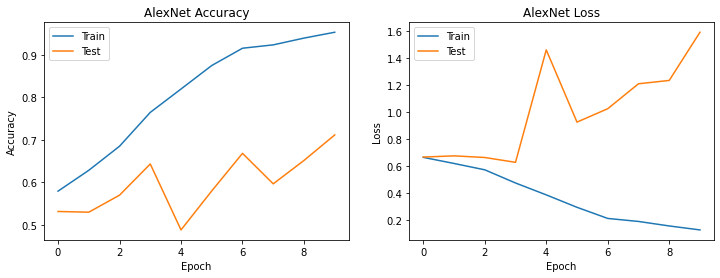

In [15]:
plot_history(alexnet_history, "AlexNet")

### Plotting Confusion Matrix

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


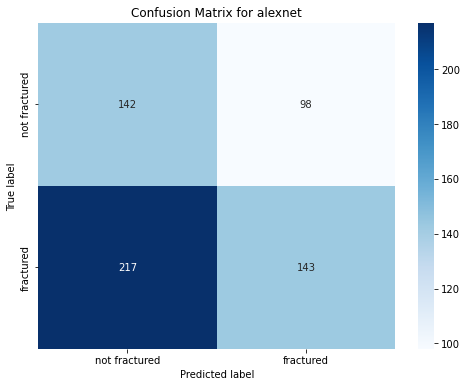

Classification Report for alexnet:

               precision    recall  f1-score   support

not fractured       0.40      0.59      0.47       240
    fractured       0.59      0.40      0.48       360

     accuracy                           0.47       600
    macro avg       0.49      0.49      0.47       600
 weighted avg       0.51      0.47      0.48       600

Accuracy for alexnet: 0.47


<Figure size 432x288 with 0 Axes>

In [16]:
# Generate predictions from the test data
y_pred = alexnet_model.predict(test_generator)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "alexnet")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "alexnet")

## 3. VGG16

In [17]:
# Generating data for VGG input shape
train_generator  = datagen_train_dir(train_dir,(224,224))
test_generator = datagen_test_dir(test_dir,(224,224))

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### 3.1. VGG16 built-in Keras

In [18]:
# Load VGGNet file and the model in it
import VGGNet

vgg_model = VGGNet.VGG()

# Compile the model
vgg_model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# vgg_model.summary()

In [19]:
hist = vgg_model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs=10,
)

Epoch 1/10


/home/rahkooy/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 2271s 8s/step - accuracy: 0.5013 - loss: 1.2015 - val_accuracy: 0.6000 - val_loss: 0.6913
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1222s 4s/step - accuracy: 0.5114 - loss: 0.6929 - val_accuracy: 0.6000 - val_loss: 0.6911
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1182s 4s/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6911
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1204s 4s/step - accuracy: 0.5074 - loss: 0.6930 - val_accuracy: 0.6000 - val_loss: 0.6910
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1202s 4s/step - accuracy: 0.5056 - loss: 0.6930 - val_accuracy: 0.6000 - val_loss: 0.6911
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1191s 4s/step - accuracy: 0.5114 - loss: 0.6929 - val_accuracy: 0.6000 - val_loss: 0.6912
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1206s 4s/step - accuracy: 0.5076 - loss: 0.6930 - val_accuracy: 0.6000 - val_loss: 0.6924
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1194s 4s/step - accuracy: 0.5023 - loss: 0.6931 - val_accurac

In [20]:
# Evaluate the model
loss, accuracy = vgg_model.evaluate(test_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5929 - loss: 0.6904
Validation Loss: 0.6901478171348572
Validation Accuracy: 0.6000000238418579


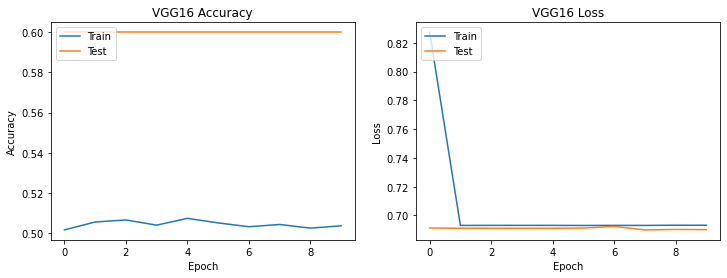

In [21]:
# plot accuracy and loss vs epoch
plot_history(hist, "VGG16")

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


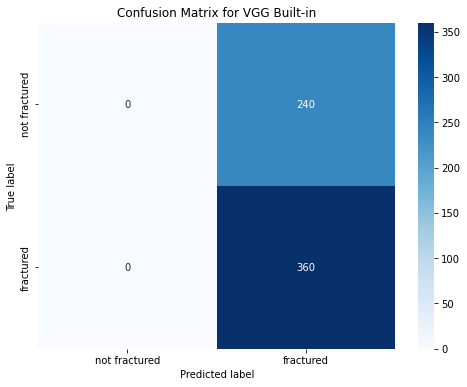

Classification Report for VGG Built-in:

               precision    recall  f1-score   support

not fractured       0.00      0.00      0.00       240
    fractured       0.60      1.00      0.75       360

     accuracy                           0.60       600
    macro avg       0.30      0.50      0.38       600
 weighted avg       0.36      0.60      0.45       600

Accuracy for VGG Built-in: 0.60


/home/rahkooy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rahkooy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rahkooy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 432x288 with 0 Axes>

In [22]:
# Generate predictions from the test data
y_pred = vgg_model.predict(test_generator)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "VGG Built-in")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "VGG Built-in")

### 3.2. VGG16 Implemented from Scratch

In [23]:
import VGGNet

vgg16_model = VGGNet.VGG16_scratch()

# Compile the model
vgg16_model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# vgg16_model.summary()

/home/rahkooy/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
hist = vgg16_model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs=10,
)

Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1233s 4s/step - accuracy: 0.4885 - loss: 0.6975 - val_accuracy: 0.6000 - val_loss: 0.6917
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1203s 4s/step - accuracy: 0.5084 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6916
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1237s 4s/step - accuracy: 0.5041 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6921
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1212s 4s/step - accuracy: 0.5016 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6913
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1221s 4s/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6912
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1209s 4s/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6912
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1203s 4s/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6914
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1197s 4s/step - accuracy: 0.5115 - loss: 0.6930 - 

In [25]:
# Evaluate the model
loss, accuracy = vgg16_model.evaluate(test_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6110 - loss: 0.6908
Validation Loss: 0.6910750865936279
Validation Accuracy: 0.6000000238418579


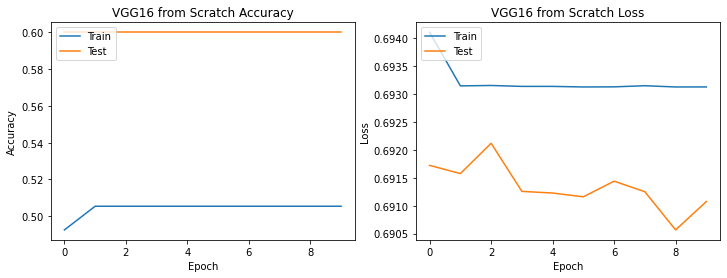

In [26]:
# plot accuracy and loss vs epoch
plot_history(hist, "VGG16 from Scratch")

19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


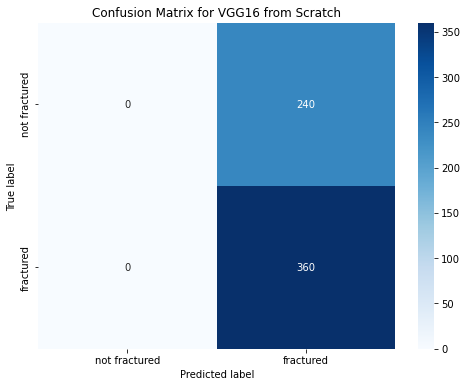

Classification Report for VGG16 from Scratch:

               precision    recall  f1-score   support

not fractured       0.00      0.00      0.00       240
    fractured       0.60      1.00      0.75       360

     accuracy                           0.60       600
    macro avg       0.30      0.50      0.38       600
 weighted avg       0.36      0.60      0.45       600

Accuracy for VGG16 from Scratch: 0.60


/home/rahkooy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rahkooy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rahkooy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 432x288 with 0 Axes>

In [27]:
# Generate predictions from the test data
y_pred = vgg16_model.predict(test_generator)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "VGG16 from Scratch")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "VGG16 from Scratch")

## 4. InceptionV3 (built-in Keras)

In [28]:
# Generating data for InceptionV3 w input shape (299,299,3)
train_generator  = datagen_train_dir(train_dir,(299, 299))
test_generator = datagen_test_dir(test_dir,(299, 299))

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [29]:
import InceptionV3 as inception_V3

InceptionV3_model = inception_V3.Inception_V3()

# Compile the model
InceptionV3_model.compile(optimizer=Adam(),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# InceptionV3_model.summary()

In [30]:
hist = InceptionV3_model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs=10,
)

Epoch 1/10


/home/rahkooy/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 1326s 5s/step - accuracy: 0.7207 - loss: 0.5923 - val_accuracy: 0.6483 - val_loss: 2.4860
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 842s 3s/step - accuracy: 0.9305 - loss: 0.1879 - val_accuracy: 0.6333 - val_loss: 2.2792
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 838s 3s/step - accuracy: 0.9666 - loss: 0.0949 - val_accuracy: 0.5433 - val_loss: 2.5702
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 846s 3s/step - accuracy: 0.9749 - loss: 0.0745 - val_accuracy: 0.7567 - val_loss: 1.1031
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 833s 3s/step - accuracy: 0.9804 - loss: 0.0610 - val_accuracy: 0.6517 - val_loss: 7.0889
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.9864 - loss: 0.0431 - val_accuracy: 0.8133 - val_loss: 0.7503
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 852s 3s/step - accuracy: 0.9842 - loss: 0.0440 - val_accuracy: 0.6667 - val_loss: 0.5926
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 843s 3s/step - accuracy: 0.9899 - loss: 0.0352 - val_accuracy: 0.82

In [31]:
# Evaluate the model
loss, accuracy = InceptionV3_model.evaluate(test_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 631ms/step - accuracy: 0.6487 - loss: 2.0686
Validation Loss: 1.9988982677459717
Validation Accuracy: 0.6583333611488342


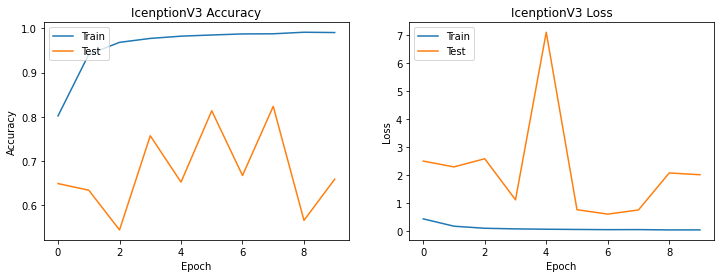

In [32]:
# plot accuracy and loss vs epoch
plot_history(hist, "IcenptionV3")

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 806ms/step


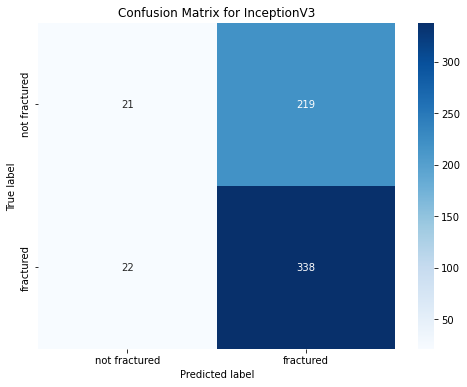

Classification Report for InceptionV3:

               precision    recall  f1-score   support

not fractured       0.49      0.09      0.15       240
    fractured       0.61      0.94      0.74       360

     accuracy                           0.60       600
    macro avg       0.55      0.51      0.44       600
 weighted avg       0.56      0.60      0.50       600

Accuracy for InceptionV3: 0.60


<Figure size 432x288 with 0 Axes>

In [33]:
# Generate predictions from the test data
y_pred = InceptionV3_model.predict(test_generator)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "InceptionV3")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "InceptionV3")

## 5. ResNet (ResNet50)

### 5.1. Model: Built-in ResNet50 with only one Fully Connected Layer

In [34]:
# Generating data for VGG input shape
train_generator  = datagen_train_dir(train_dir,(224, 224))
test_generator = datagen_test_dir(test_dir,(224, 224))

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [35]:
import ResNet50

resnet50_seq_model = ResNet50.resnet50_seq()

# Compile the model
resnet50_seq_model.compile(optimizer=Adam(),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# resnet50_model.summary()

In [36]:
resnet50_seq_history = resnet50_seq_model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs=10,
)

Epoch 1/10


/home/rahkooy/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 1236s 4s/step - accuracy: 0.6323 - loss: 0.6791 - val_accuracy: 0.6000 - val_loss: 19.2430
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 1195s 4s/step - accuracy: 0.7772 - loss: 0.4674 - val_accuracy: 0.6000 - val_loss: 0.6962
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 752s 3s/step - accuracy: 0.8672 - loss: 0.3145 - val_accuracy: 0.6000 - val_loss: 9.0174
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 729s 3s/step - accuracy: 0.9276 - loss: 0.1823 - val_accuracy: 0.5583 - val_loss: 2.5917
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 746s 3s/step - accuracy: 0.9357 - loss: 0.1559 - val_accuracy: 0.6600 - val_loss: 3.8817
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 725s 3s/step - accuracy: 0.9687 - loss: 0.0884 - val_accuracy: 0.5833 - val_loss: 1.2407
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 746s 3s/step - accuracy: 0.9727 - loss: 0.0789 - val_accuracy: 0.6617 - val_loss: 1.6607
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 729s 3s/step - accuracy: 0.9803 - loss: 0.0547 - val_accuracy: 0.

In [37]:
# Evaluate the model
loss, accuracy = resnet50_seq_model.evaluate(test_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 550ms/step - accuracy: 0.7111 - loss: 1.8174
Validation Loss: 2.0368494987487793
Validation Accuracy: 0.675000011920929


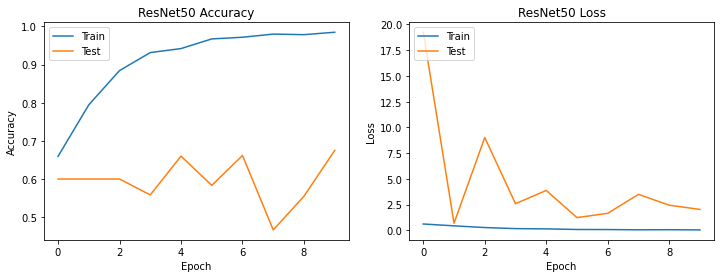

In [38]:
# plot accuracy and loss vs epoch
plot_history(resnet50_seq_history, "ResNet50")

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 662ms/step


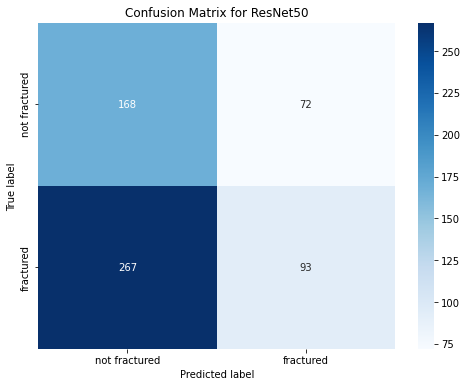

Classification Report for ResNet50:

               precision    recall  f1-score   support

not fractured       0.39      0.70      0.50       240
    fractured       0.56      0.26      0.35       360

     accuracy                           0.43       600
    macro avg       0.47      0.48      0.43       600
 weighted avg       0.49      0.43      0.41       600

Accuracy for ResNet50: 0.43


<Figure size 432x288 with 0 Axes>

In [39]:
# Generate predictions from the test data
y_pred = resnet50_seq_model.predict(test_generator)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "ResNet50")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "ResNet50")

### 5.2. Built-in base model nontrainable with only one added fully connected layer

In [40]:
import ResNet50

resnet50_nontrain_model = ResNet50.resnet50_nontrain()

# Compile the model
resnet50_nontrain_model.compile(optimizer=Adam(),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# resnet50_model.summary()

In [41]:
resnet50_history = resnet50_nontrain_model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs=10,
)

Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 243s 840ms/step - accuracy: 0.5141 - loss: 0.7109 - val_accuracy: 0.7233 - val_loss: 0.6446
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.5564 - loss: 0.6778 - val_accuracy: 0.6000 - val_loss: 0.6541
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.5710 - loss: 0.6759 - val_accuracy: 0.6400 - val_loss: 0.6634
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.5878 - loss: 0.6623 - val_accuracy: 0.5783 - val_loss: 0.6231
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.5820 - loss: 0.6642 - val_accuracy: 0.6950 - val_loss: 0.6337
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.5915 - loss: 0.6549 - val_accuracy: 0.5583 - val_loss: 0.6899
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.6084 - loss: 0.6489 - val_accuracy: 0.5317 - val_loss: 0.6190
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.5864 - loss: 0.6554 - val_a

In [42]:
# Evaluate the model
loss, accuracy = resnet50_nontrain_model.evaluate(test_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 873ms/step - accuracy: 0.6725 - loss: 0.6490
Validation Loss: 0.6390774250030518
Validation Accuracy: 0.6899999976158142


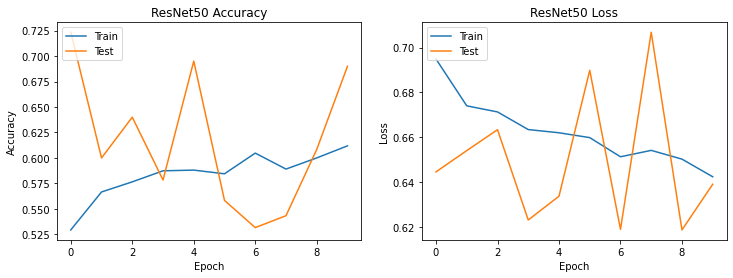

In [43]:
# plot accuracy and loss vs epoch
plot_history(resnet50_history, "ResNet50")

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 949ms/step


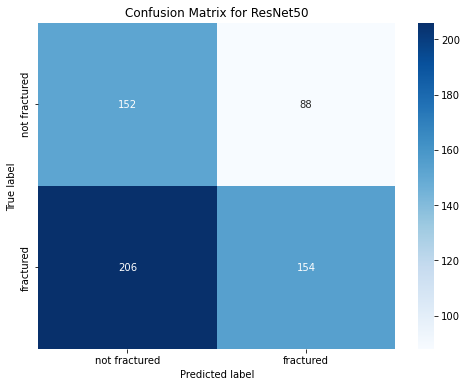

Classification Report for ResNet50:

               precision    recall  f1-score   support

not fractured       0.42      0.63      0.51       240
    fractured       0.64      0.43      0.51       360

     accuracy                           0.51       600
    macro avg       0.53      0.53      0.51       600
 weighted avg       0.55      0.51      0.51       600

Accuracy for ResNet50: 0.51


<Figure size 432x288 with 0 Axes>

In [44]:
# Generate predictions from the test data
y_pred = resnet50_nontrain_model.predict(test_generator)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "ResNet50")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "ResNet50")

### 5.3. Model: Built-in Resnet50 with several normalisation layers added

In [45]:
# Generating data for VGG input shape
train_generator  = datagen_train_dir(train_dir,(224, 224))
test_generator = datagen_test_dir(test_dir,(224, 224))

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [46]:
import ResNet50

resnet50_model = ResNet50.resnet50_nontrain_normalised()

# Compile the model
resnet50_model.compile(optimizer=Adam(),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# resnet50_model.summary()

In [47]:
resnet50_history = resnet50_model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs=10,
)

Epoch 1/10


/home/rahkooy/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.5555 - loss: 0.8023 - val_accuracy: 0.5067 - val_loss: 0.7333
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.5797 - loss: 0.6940 - val_accuracy: 0.6167 - val_loss: 0.6551
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.6088 - loss: 0.6518 - val_accuracy: 0.6050 - val_loss: 0.6603
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.6611 - loss: 0.6166 - val_accuracy: 0.6083 - val_loss: 0.6591
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.6766 - loss: 0.5872 - val_accuracy: 0.5933 - val_loss: 0.6885
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.6928 - loss: 0.5789 - val_accuracy: 0.6100 - val_loss: 0.6321
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.7072 - loss: 0.5572 - val_accuracy: 0.6117 - val_loss: 0.6942
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.7212 - loss: 0.5366 - val_accuracy: 0.663

In [49]:
# Evaluate the model
loss, accuracy = resnet50_model.evaluate(test_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 878ms/step - accuracy: 0.5936 - loss: 0.7733
Validation Loss: 0.737479031085968
Validation Accuracy: 0.5983333587646484


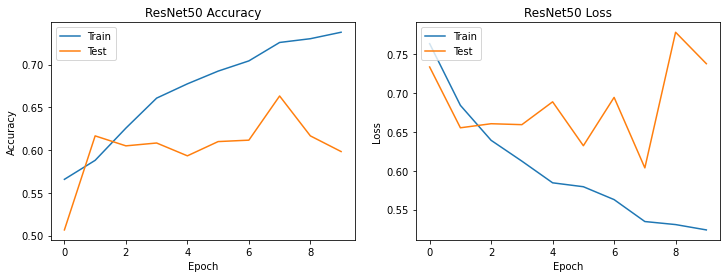

In [50]:
# plot accuracy and loss vs epoch
plot_history(resnet50_history, "ResNet50")

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 966ms/step


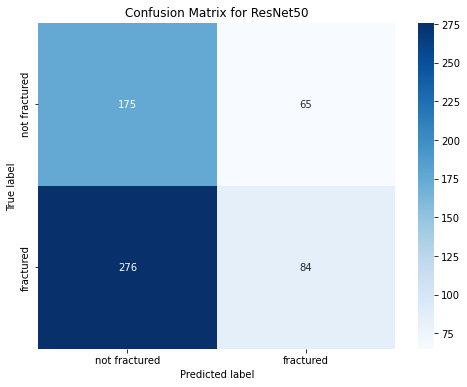

Classification Report for ResNet50:

               precision    recall  f1-score   support

not fractured       0.39      0.73      0.51       240
    fractured       0.56      0.23      0.33       360

     accuracy                           0.43       600
    macro avg       0.48      0.48      0.42       600
 weighted avg       0.49      0.43      0.40       600

Accuracy for ResNet50: 0.43


<Figure size 432x288 with 0 Axes>

In [51]:
# Generate predictions from the test data
y_pred = resnet50_model.predict(test_generator)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "ResNet50")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "ResNet50")

### 5.4. Data: Images with rotation/height/width adjusting
###    Model: Built-in Resnet50 with several normalisation layers added

In [52]:
train_dir = "train"
test_dir = "test"

# Data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_test = ImageDataGenerator(
    rescale=1./255
)

def datagen_train_dir(dir,in_shape):
    generator = datagen_train.flow_from_directory(
        dir,
        target_size=(in_shape[0], in_shape[1]), 
        batch_size= 32,
        class_mode='binary',  # Since class_mode is binary, labels will be 0 or 1
        classes=['not fractured', 'fractured']  # Specify the class labels explicitly
        )
    return generator

def datagen_test_dir(dir,in_shape):
    generator = datagen_test.flow_from_directory(
        dir,
        target_size=(in_shape[0], in_shape[1]), 
        batch_size=32,
        class_mode='binary',  # Since class_mode is binary, labels will be 0 or 1
        classes=['not fractured', 'fractured']  # Specify the class labels explicitly
        )
    return generator

# Generating data for VGG input shape
train_generator  = datagen_train_dir(train_dir,(224, 224))
test_generator = datagen_test_dir(test_dir,(224, 224))

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [53]:
import ResNet50

resnet50_model = ResNet50.resnet50_nontrain_normalised()

# Compile the model
resnet50_model.compile(optimizer=Adam(),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

resnet50_model.summary()

Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,722,497 (189.68 MB)

 Trainable params: 25,933,185 (98.93 MB)

 Non-trainable params: 23,789,312 (90.75 MB)

In [55]:
resnet50_history = resnet50_model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs=10,
)

Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.5888 - loss: 0.6728 - val_accuracy: 0.6233 - val_loss: 0.6112
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.5889 - loss: 0.6653 - val_accuracy: 0.6483 - val_loss: 0.5947
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.5931 - loss: 0.6609 - val_accuracy: 0.6433 - val_loss: 0.6020
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.6068 - loss: 0.6489 - val_accuracy: 0.6200 - val_loss: 0.6047
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 268s 958ms/step - accuracy: 0.6083 - loss: 0.6481 - val_accuracy: 0.6483 - val_loss: 0.6164
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 262s 926ms/step - accuracy: 0.6155 - loss: 0.6426 - val_accuracy: 0.6400 - val_loss: 0.5909
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 257s 907ms/step - accuracy: 0.6192 - loss: 0.6493 - val_accuracy: 0.6350 - val_loss: 0.6025
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.6161 - loss: 0.6470 -

In [56]:
# Evaluate the model
loss, accuracy = resnet50_model.evaluate(test_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 815ms/step - accuracy: 0.6357 - loss: 0.6426
Validation Loss: 0.6382807493209839
Validation Accuracy: 0.6566666960716248


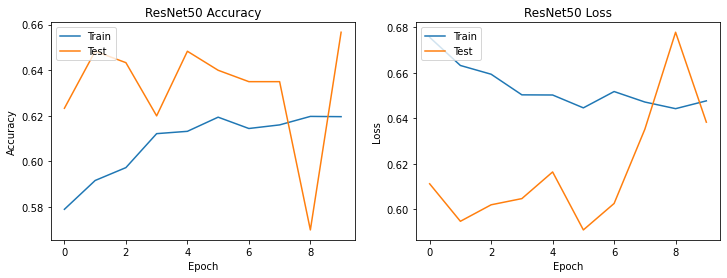

In [58]:
# plot accuracy and loss vs epoch
plot_history(resnet50_history, "ResNet50")

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 951ms/step


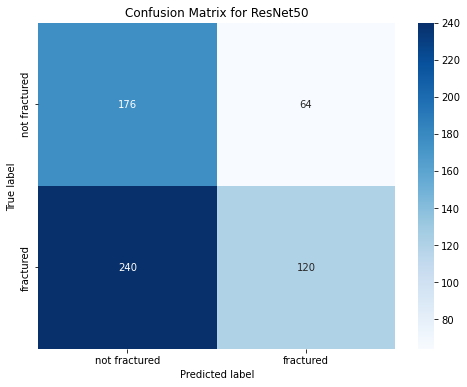

Classification Report for ResNet50:

               precision    recall  f1-score   support

not fractured       0.42      0.73      0.54       240
    fractured       0.65      0.33      0.44       360

     accuracy                           0.49       600
    macro avg       0.54      0.53      0.49       600
 weighted avg       0.56      0.49      0.48       600

Accuracy for ResNet50: 0.49


<Figure size 432x288 with 0 Axes>

In [60]:
# Generate predictions from the test data
y_pred = resnet50_model.predict(test_generator)

# Since y_pred is in probabilities, we need to convert them to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get the true labels from the test data
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
plot_confusion_matrix(cm, "ResNet50")

# Print the classification report and accuracy
print_classification_report(y_true, y_pred_binary, "ResNet50")

## Model Comparison

| Metric | LeNet | AlexNet | VGG  Built-In | VGG from Scratch | InceptionV3 | ResNet50 Built-in | ResNet50 Built-in & nontrain| ResNet  Built-in & nontrainable & Normalised | ResNet Built-in & nontrain  & normalised & Data adjusted |
|:------:|:-----:|:-------:|:-------------:|:----------------:|:-----------:|:-----------------:|:----------------------------:|:-------------------------------------------:|:-------------------------------------------------------:|
| Accuracy|   0.51   |     0.47    |         0.66      |        0.60         |        0.60      |         0.43          |                                         0.51   |      0.43    | 0.49
|Precesion|   0.53   |    0.51     |      0.36         |       0.36          |     0.56         |          0.49         |                                       0.55     |     0.49    | 0.56 
|Recall|   0.51   |     0.47    |         0.60      |        0.60         |      0.60        |          0.43         |                                       0.51     |      0.443   |  0.49
|F1-Score|    0.51  |     0.48    |       0.45        |        0.45         |     0.50         |            0.41       |                                        0.51    |     0.40     | 0.48

